# 01 Show Me the Data!

Welcome to the first BCI Essentials tutorial notebook. In this notebook we will explore:

- How to load a previously collected session of BCI data
- How to extract key data, like sampling rate and channel labels
- How to plot EEG data
- How to bandpass filter EEG data

Note: If you have not already, you will have to install the ipykernel package to
run this notebook. You can do this from your terminal with "pip install ipykernel"

## Loading a previous session of data

When BCI data is collected using bci-essentials-python and bci-essentials-unity 
it is saved to a single XDF (.xdf) file. Each file consists of multiple 
"streams". One stream contains EEG data from the headset. Another stream 
contains marker data from Unity telling us what stimulus or feedback was given. 
Another stream includes the BCI selections made by the Python backend.

We will initialize a data object and load the offline data into it from an XDF 
file. This does the work of extracting all of the available data from the 
streams and storing it in a uniform format for access later on.

In this tutorial we will only focus on the EEG stream.



In [13]:
# Import the bci_data module to load and process the data
from bci_essentials.bci_data import *

# Get the path of the file we want to open
filename = "examples\\data\\mi_example.xdf"

# Initialize data object
bci_data = EEG_data()

# Load the XDF file into an EEG_data object
bci_data.load_offline_eeg_data(filename  = filename, print_output=False)

# Check that it worked by printing the channel labels and sampling rate
print("The channel labels are:", bci_data.channel_labels)
print("The sampling rate is:", bci_data.fsample)

The channel labels are: ['FC3', 'FCz', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'Pz']
The sampling rate is: 256.0


## Plot the EEG Data

Now that we have loaded our EEG data, the raw EEG is accessible in
bci_data.eeg_data and the timestamps are available in bci.eeg_timestamps.

First, lets check to make sure that the sizes of these arrays match.

In [14]:
# Get the shape of the EEG and timestamp arrays
raw_eeg_shape = bci_data.eeg_data.shape
print("The shape of the EEG data is: " + str(raw_eeg_shape))

raw_timestamps_shape = bci_data.eeg_timestamps.shape
print("The shape of the EEG timestamps is: " + str(raw_timestamps_shape))

# Print the number of channels
print("The number of channels is: " + str(bci_data.nchannels))

The shape of the EEG data is: (125952, 16)
The shape of the EEG timestamps is: (125952,)
The number of channels is: 16


From this we can see that the shape of the first dimension of the array matches
the number of samples and the second dimension matches the number of channels,
which also matches the number of channel labels from earlier!

Now we can create our plot of the EEG data!

['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
['microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts']


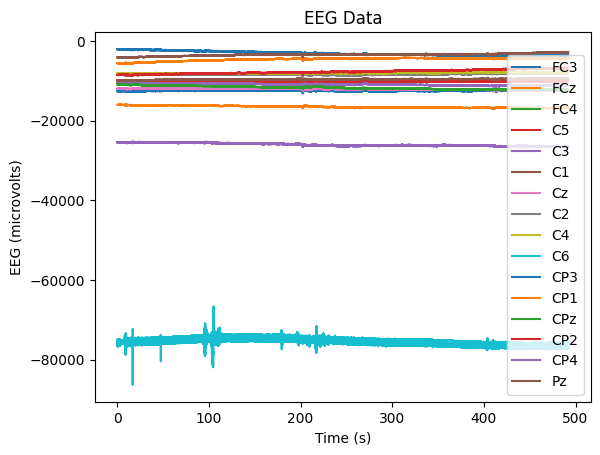

In [16]:
import matplotlib.pyplot as plt

# Find out which channels contain EEG data, in this case it is all of them
print(bci_data.ch_type)

# Get the units for our plot, they are all the same, so set units to "microvolts"
print(bci_data.ch_units)
units = "microvolts"

# Get the raw EEG and Timestamps
raw_eeg = bci_data.eeg_data.T
timestamps = bci_data.eeg_timestamps

# Subtract the initial time from the timestamps to get a time starting at 0
timestamps = timestamps - timestamps[0]


# Plot the EEG data
plt.figure()
plt.plot(timestamps, raw_eeg.T)
plt.xlabel("Time (s)")
plt.ylabel("EEG (" + units + ")")
plt.title("EEG Data")
plt.legend(bci_data.channel_labels)
plt.show()

Well... technically this does show our EEG data, but not very well. There are a 
few issues left to resolve. Primarily we can see that all of the signals have a 
different DC offset. We also see that the signals have some low frequency drift 
(visible in C6 and CP1).

To handle these issues, lets filter the signal with a bandpass filter using the 
signal processing module. Our main target right now is the low frequencies, so 
we will make a bandpass filter which passes frequencies between 1 and 100 Hz. 

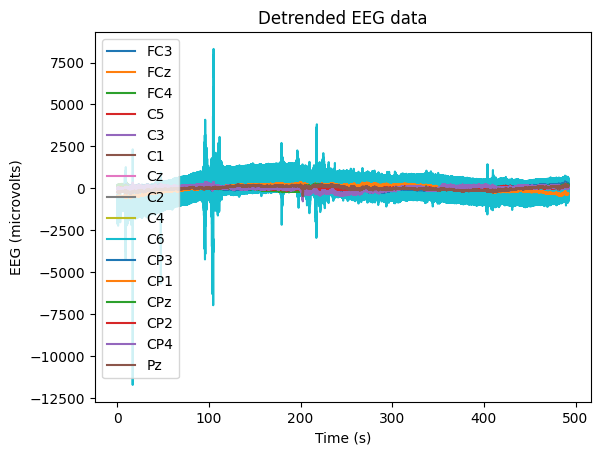

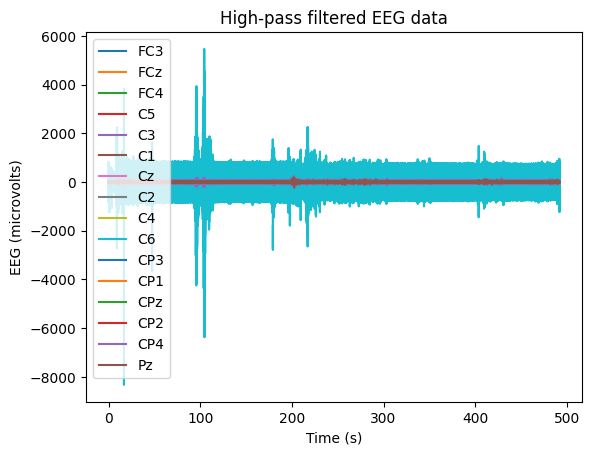

In [17]:
from bci_essentials.signal_processing import bandpass

# Import detrend from scipy.signal
from scipy.signal import detrend

# Remove the DC offset
dc_rejected_eeg = detrend(raw_eeg)

# Plot the high pass filtered data
# Plot the EEG data
plt.figure()
plt.plot(timestamps, dc_rejected_eeg.T)
plt.xlabel("Time (s)")
plt.ylabel("EEG (" + units + ")")
plt.title("Detrended EEG data")
plt.legend(bci_data.channel_labels)
plt.show()

# Apply the filter to the data
high_pass_filt_eeg = bandpass(dc_rejected_eeg, 
              f_low=1, 
              f_high=100, 
              order=5, 
              fsample=bci_data.fsample)


# Plot the high pass filtered data
# Plot the EEG data
plt.figure()
plt.plot(timestamps, high_pass_filt_eeg.T)
plt.xlabel("Time (s)")
plt.ylabel("EEG (" + units + ")")
plt.title("High-pass filtered EEG data")
plt.legend(bci_data.channel_labels)
plt.show()



This is ... better, we don't have the DC offset anymore and the peaks in C6
aren't quite as prominent. But we still have lots of noise, we can plot the 
power spectral density of the signal to see where that noise is coming from.

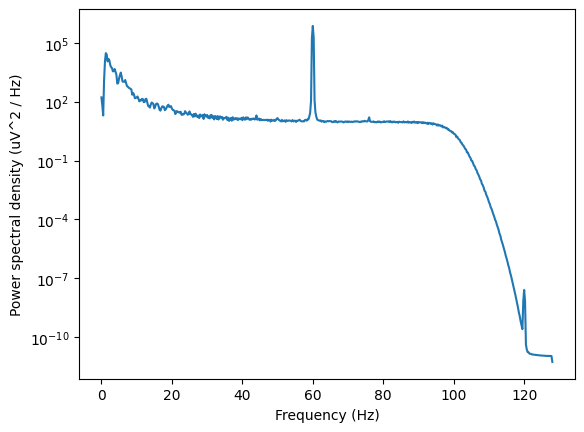

In [19]:
# Plot the PSD of P6

# Import the modules you need
from scipy.signal import welch

# Calculate the PSD of P6 using welch()
freqs, psd = welch(high_pass_filt_eeg[9,:], fs=bci_data.fsample, nperseg=1024)

# Plot the PSD
plt.semilogy(freqs, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.show()



Ouuuup there it is! This PSD shows us that we are getting a lot of noise at
60Hz and 120Hz due to the 60Hz interference from our 60Hz electrical grid. 
Because we aren't really interested in frequencies above 60 Hz anyway let's
remove this by reselecting the cutoffs of our bandpass filter to be 1-40 Hz.

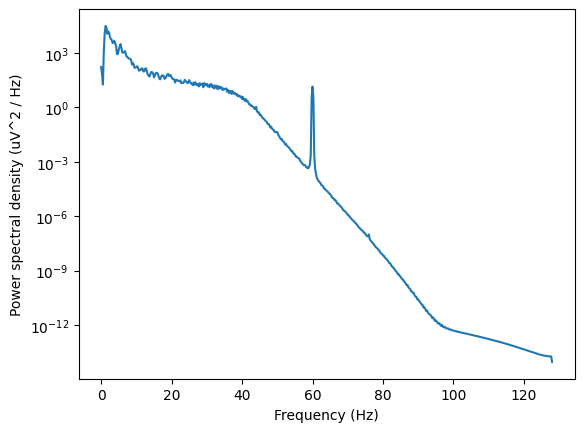

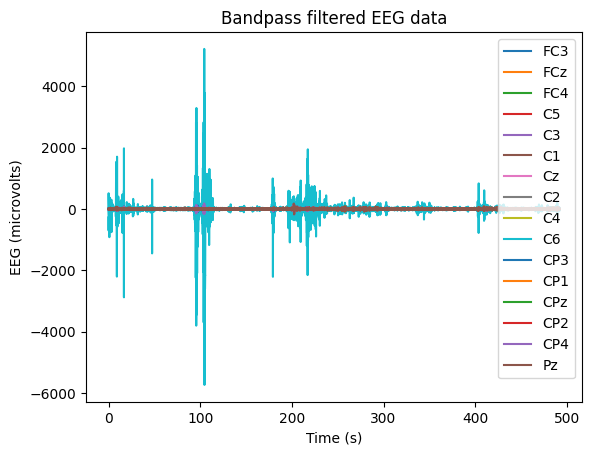

In [22]:
# Apply the filter to the data
bandpass_filt_eeg = bandpass(dc_rejected_eeg, 
              f_low=1, 
              f_high=40, 
              order=5, 
              fsample=bci_data.fsample)

# Use C6 to check that the correct frequencies were removed

# Calculate the PSD of P6 using welch()
bandpass_freqs, bandpass_psd = welch(bandpass_filt_eeg[9,:], fs=bci_data.fsample, nperseg=1024)

# Plot the PSD
plt.semilogy(bandpass_freqs, bandpass_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.show()


# Plot the bandpass filtered data
# Plot the EEG data
plt.figure()
plt.plot(timestamps, bandpass_filt_eeg.T)
plt.xlabel("Time (s)")
plt.ylabel("EEG (" + units + ")")
plt.title("Bandpass filtered EEG data")
plt.legend(bci_data.channel_labels)
plt.show()

Much better ... well except for C6. Sometimes there is nothing you can do to 
improve the quality of a channel. 

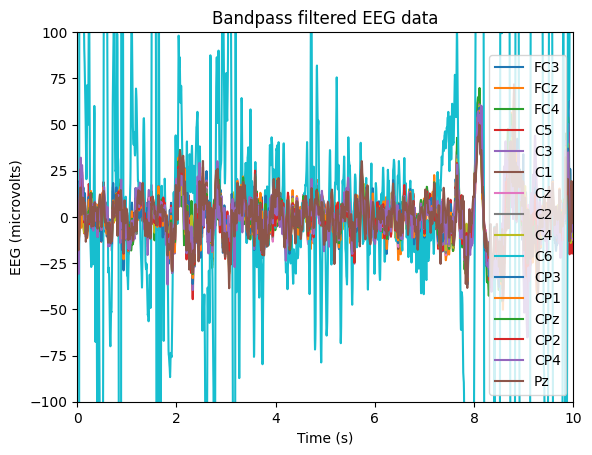

In [25]:
# Plot the bandpass filtered data
# Plot the EEG data
plt.figure()
plt.plot(timestamps, bandpass_filt_eeg.T)
plt.ylim([-100, 100])
plt.xlim([0, 10])
plt.xlabel("Time (s)")
plt.ylabel("EEG (" + units + ")")
plt.title("Bandpass filtered EEG data")
plt.legend(bci_data.channel_labels)
plt.show()